In [1]:
from datetime import date, timedelta
import time
import pandas_datareader.data as pdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#plt.style.use('ggplot')

### Using Monte-Carlo method for finding optimal Sharpe ratios in cryptocurrency portfolios

First, we'll use the yahoo finance API to get stock price data for four coins--bitcoin, ethereum, litecoin, and ripple

In [2]:
stocks = ['BTC-USD', 'ETH-USD', 'LTC-USD','XRP-USD']

In [3]:
def get_data(tickers, start_date, end_date):
    """Read in daily price(adjusted close) of asset from CSV files for a given set of dates."""
    
    # download daily price data for each of the stocks in the portfolio
    df = pdr.get_data_yahoo(stocks, start=start_date, end = end_date)['Adj Close']
    df.sort_index(inplace = True)
    
    return df

In [4]:
yesterday = date.today() - timedelta(2)
crypto_prices = get_data(stocks, '01/01/2017', yesterday.strftime("%d/%m/%Y") )
print(crypto_prices.tail())

Symbols          BTC-USD      ETH-USD     LTC-USD   XRP-USD
Date                                                       
2021-02-22  54207.320312  1781.992920  208.106796  0.571741
2021-02-23  48824.425781  1570.203979  176.934921  0.473563
2021-02-24  49705.332031  1626.575684  181.378494  0.471832
2021-02-25  47093.851562  1475.703735  178.901840  0.434524
2021-02-26  46339.761719  1446.033691  170.398148  0.427900


#### Next, we'll define a function for calculating daily returns for our coins

In [5]:
def calc_daily_returns(df):
    return (df.pct_change())

In [6]:
crypto_daily_rets = calc_daily_returns(crypto_prices)
print(crypto_daily_rets.head())

Symbols      BTC-USD   ETH-USD   LTC-USD   XRP-USD
Date                                              
2017-01-01       NaN       NaN       NaN       NaN
2017-01-02  0.023464  0.025199  0.030444 -0.008951
2017-01-03  0.021620  0.160737 -0.004891  0.011884
2017-01-04  0.106233  0.156947  0.045750  0.028813
2017-01-05 -0.122410 -0.088627 -0.112680 -0.056164


#### Define a function for calculating mean daily returns for our coins

In [7]:
def calc_mean_daily_returns(daily_returns):
    return (daily_returns.mean())

In [8]:
crypto_mean_daily_rets = calc_mean_daily_returns(crypto_daily_rets)
print(crypto_mean_daily_rets.head())

Symbols
BTC-USD    0.003452
ETH-USD    0.005053
LTC-USD    0.004300
XRP-USD    0.005921
dtype: float64


#### Define a function for creating covariance matrices

In [9]:
def create_covariance_matrix(daily_returns):
    return daily_returns.cov()

In [10]:
crypto_cov_matrix = create_covariance_matrix(crypto_daily_rets)
print(crypto_cov_matrix)

Symbols   BTC-USD   ETH-USD   LTC-USD   XRP-USD
Symbols                                        
BTC-USD  0.001809  0.001566  0.001681  0.001265
ETH-USD  0.001566  0.003271  0.002242  0.001855
LTC-USD  0.001681  0.002242  0.003995  0.002210
XRP-USD  0.001265  0.001855  0.002210  0.007852


#### Below is a function to calculate and return a dataframe with portfolio returns, standard deviations, and sharpe ratios for a specified number of randomly weighted portfolios consisting of our four coins

In [11]:
def create_results_dataframe(tickers, number_portfolios, mean_daily_returns, cov_matrix):
    results_temp = np.zeros((4 + len(tickers) - 1, number_portfolios))

    for i in range(number_portfolios):
        # select random weights for portfolio holdings
        weights = np.array(np.random.random(4))
        
        # rebalance weights to sum to 1
        weights /= np.sum(weights)

        # calculate portfolio return and volatility
        portfolio_return = np.sum(mean_daily_returns * weights) * 252
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)

        # 3 month T-Bill yield used as risk free rate of return
        risk_free_return = 0.0139

        # store results in results array
        results_temp[0, i] = portfolio_return
        results_temp[1, i] = portfolio_std_dev
        
        # store Sharpe Ratio (return / volatility) - risk free rate element excluded for simplicity
        results_temp[2, i] = (results_temp[0, i] - risk_free_return) / results_temp[1, i]
        
        # iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_temp[j + 3, i] = weights[j]

    # convert results array to Pandas DataFrame
    results_df = pd.DataFrame(results_temp.T, columns=['ret', 'stdev', 'sharpe', tickers[0], 
                                                       tickers[1], tickers[2], tickers[3]])
    
    return results_df

In [12]:
crypto_results = create_results_dataframe(stocks, 10000, crypto_mean_daily_rets, crypto_cov_matrix)
print(crypto_results.head())

        ret     stdev    sharpe   BTC-USD   ETH-USD   LTC-USD   XRP-USD
0  1.148406  0.773659  1.466417  0.270479  0.186962  0.329233  0.213326
1  1.176605  0.765080  1.519717  0.311757  0.270963  0.152419  0.264862
2  1.206805  0.853978  1.396880  0.220462  0.089415  0.314639  0.375484
3  0.990354  0.706778  1.381557  0.570451  0.086872  0.312900  0.029777
4  1.162348  0.771710  1.488186  0.222122  0.293659  0.311655  0.172564


#### Define a function to find the portfolio with the highest sharpe ratio 

In [13]:
def max_sharpe_ratio(results_df):
    """locate portfolio with highest Sharpe Ratio"""
    return results_df.iloc[results_df['sharpe'].idxmax()]

In [14]:
crypto_max_sharpe_portfolio = max_sharpe_ratio(crypto_results)
print(crypto_max_sharpe_portfolio)

ret        1.160937
stdev      0.735267
sharpe     1.560027
BTC-USD    0.374293
ETH-USD    0.426052
LTC-USD    0.012575
XRP-USD    0.187080
Name: 9200, dtype: float64


#### Define a function to find the portfolio with the lowest volatility 

In [15]:
def min_volatility(results_df):
    """locate portfolio with lowest volatility"""
    return results_df.iloc[results_df['stdev'].idxmin()]

In [16]:
crypto_min_vol_portfolio = min_volatility(crypto_results)
print(crypto_min_vol_portfolio)

ret        0.971363
stdev      0.665091
sharpe     1.439596
BTC-USD    0.782556
ETH-USD    0.130095
LTC-USD    0.013300
XRP-USD    0.074049
Name: 9201, dtype: float64


#### Write func to plot all of the different portfolios consisting of different mixtures (weights) for our four coins
#### Also, plot the portfolio with teh highest Sharpe with a red star and the lowest volatility with a green star
#### Lastly, plot a color bar showing the sharpe ratio for all portfolios

In [17]:
def plot_graph(results_df, max_sharpe_port, min_vol_port):
    ax = results_df.plot(kind= 'scatter', x = 'stdev', y='ret', s = 30, 
                         c=results_df.sharpe, cmap='RdYlBu',edgecolors='.1', figsize=(20,10))
    ax.grid(False, color='w', linestyle='-', linewidth=1)
    ax.set_facecolor('0.4444')
    ax.set_xlabel('Volatility')
    ax.set_ylabel('Returns')
    ax.tick_params(labelsize = 14)

    # # plot red star to highlight position of portfolio with highest Sharpe Ratio
    ax.scatter(max_sharpe_port[1], max_sharpe_port[0], marker=(5, 1, 0), color='r', s=1000)
    # # plot green star to highlight position of minimum variance portfolio
    ax.scatter(min_vol_port[1], min_vol_port[0], marker=(5, 1, 0), color='g', s=1000)


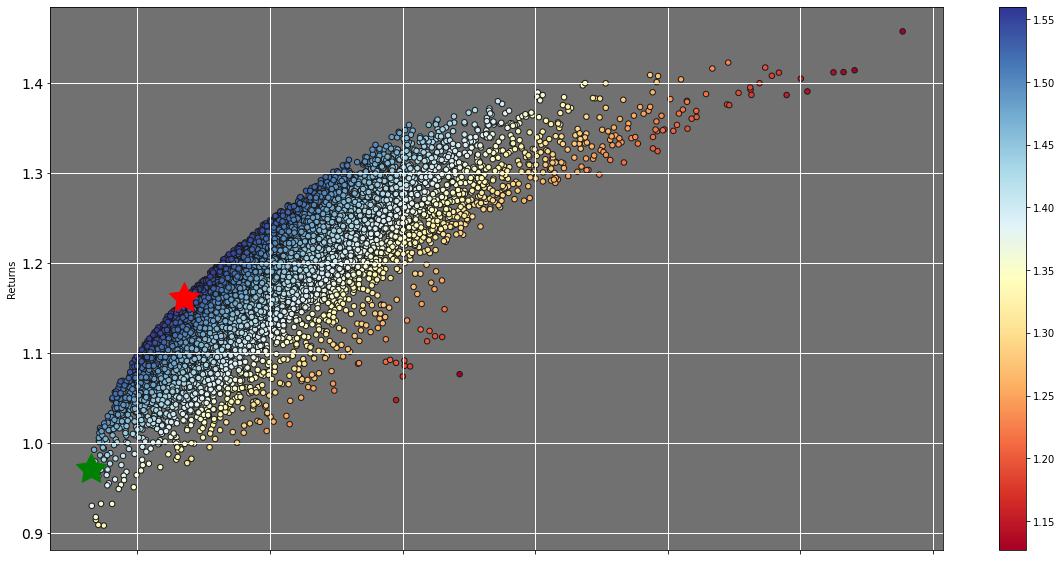

In [18]:
plot_graph(crypto_results, crypto_max_sharpe_portfolio, crypto_min_vol_portfolio)
plt.show()